In [249]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib.widgets import Slider

In [233]:
feature_paths = [
    # "./result/test_pflc/manual-collect.csv",
    "./yj3-result/exp1_pflc_betterxb/manual-collect.csv",
    "./yj3-result/exp1_pflc_buildats/manual-collect.csv",
    "./yj3-result/exp1_pflc_itsttime/manual-collect.csv",
    "./yj3-result/exp1_pflc_rmlist/manual-collect.csv",
    "./yj3-result/exp1_pflc_storesfg/manual-collect.csv",
    "./yj3-result/exp1_pflc_tpsmay22/manual-collect.csv",
]
df = pd.concat([pd.read_csv(feature_path) for feature_path in feature_paths], ignore_index=True)
df

,Unnamed: 0,oid,pod_size,pod_max_change_prob,oid_count,oid_change_count,oid_change_prob,obj_type,obj_len,has_changed
0,0,140551958097712,2,0.0,0,0,0.0,str,8.0,True
1,1,140551957833072,2,0.0,0,0,0.0,str,12.0,True
2,2,140551958219088,2,0.0,0,0,0.0,module,NaN,True
3,3,140549179146592,2,0.0,0,0,0.0,function,NaN,True
4,4,140549178756400,2,0.0,0,0,0.0,str,10.0,True
...,...,...,...,...,...,...,...,...,...,...
62586,6218,139800133981488,2,0.0,1,1,1.0,bytes,20.0,False
62587,6219,139800169487936,2,0.0,0,0,0.0,dict,1.0,False
62588,6220,139800243995584,2,0.0,1,1,1.0,dict,0.0,False
62589,6221,139800172522368,2,0.0,0,0,0.0,dict,1.0,False


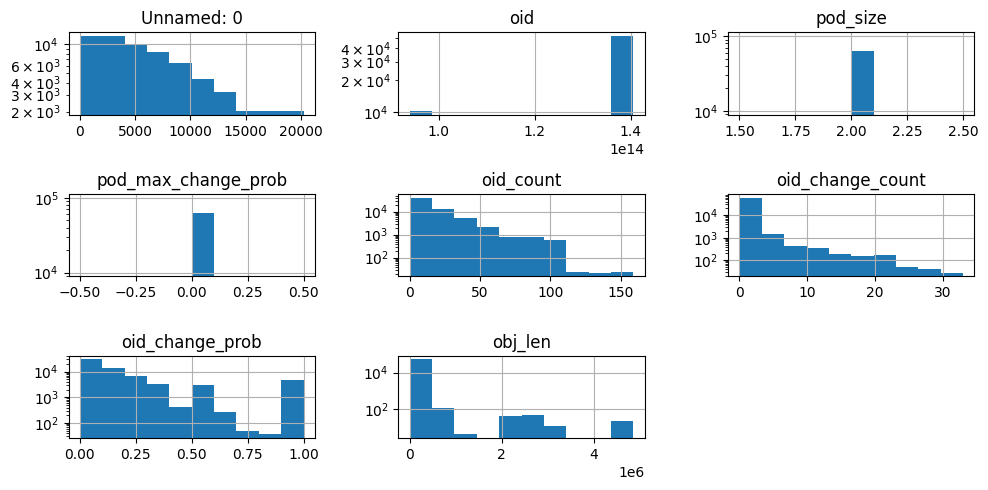

In [234]:
df.hist(figsize=(10, 5), log=True)
plt.tight_layout()
plt.show()

/var/folders/mq/s_mr5r6931595yybcg6bk32w0000gp/T/ipykernel_25784/2198673375.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


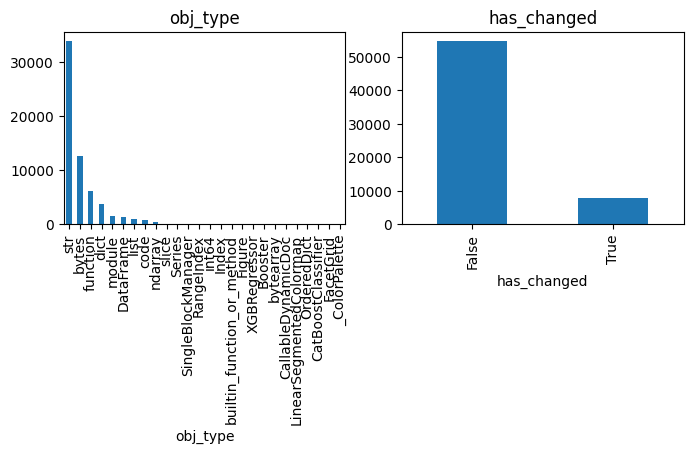

In [235]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 2.5))

df['obj_type'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('obj_type')

df['has_changed'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('has_changed')

plt.tight_layout()
plt.show()

In [236]:
X_df = df[[
    # "oid",
    "pod_size",
    "pod_max_change_prob",
    "oid_count",
    "oid_change_count",
    "oid_change_prob",
    # "obj_type",
    "obj_len",
]]
# X_df.loc[:,"obj_type"] = X_df["obj_type"].astype("category")
ys = df["has_changed"].astype("int").values
display(X_df)
display(ys)

,pod_size,pod_max_change_prob,oid_count,oid_change_count,oid_change_prob,obj_len
0,2,0.0,0,0,0.0,8.0
1,2,0.0,0,0,0.0,12.0
2,2,0.0,0,0,0.0,NaN
3,2,0.0,0,0,0.0,NaN
4,2,0.0,0,0,0.0,10.0
...,...,...,...,...,...,...
62586,2,0.0,1,1,1.0,20.0
62587,2,0.0,0,0,0.0,1.0
62588,2,0.0,1,1,1.0,0.0
62589,2,0.0,0,0,0.0,1.0


array([1, 1, 1, ..., 0, 0, 0])

In [237]:
X_df.isna().sum()

pod_size                  0
pod_max_change_prob       0
oid_count                 0
oid_change_count          0
oid_change_prob           0
obj_len                9050
dtype: int64

neg_pos_ratio=6.98341836734694


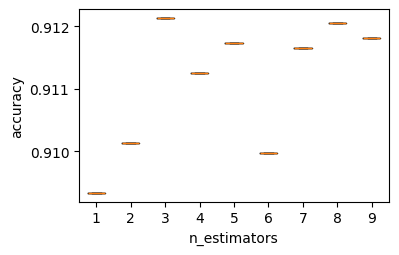

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X_df, ys, test_size=.2)
pos_fraction = y_train.sum() / len(y_train)
neg_fraction = 1 - pos_fraction
neg_pos_ratio = neg_fraction / pos_fraction
print(f"{neg_pos_ratio=}")

plt.figure(figsize=(4, 2.5))
all_accs = []
for n_estimators in xs:
    accs = []
    for _ in range(3):
        bst = XGBClassifier(enable_categorical=True, n_estimators=n_estimators, scale_pos_weight=neg_pos_ratio)
        bst.fit(X_train, y_train)
        y_test_pred = bst.predict(X_test)
        accs.append((y_test == y_test_pred).mean())
    all_accs.append(accs)
plt.boxplot(all_accs)
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.show()

In [239]:
bst = XGBClassifier(enable_categorical=True, n_estimators=3, scale_pos_weight=neg_pos_ratio)
bst.fit(X_train, y_train)
y_test_pred = bst.predict(X_test)
y_test_pred_prob = bst.predict_proba(X_test)
print((y_test == y_test_pred).mean())

0.9121335569933701


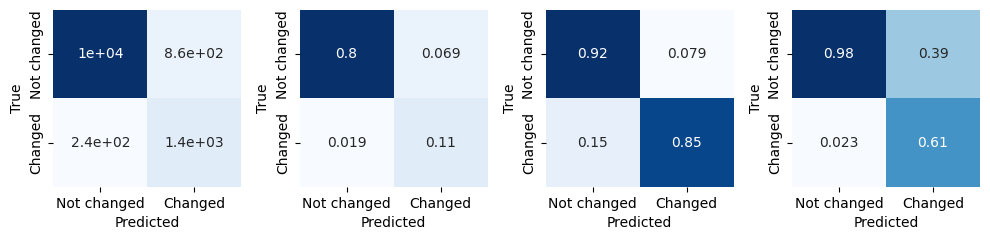

In [240]:
# Create confusion matrix
cms = [
    confusion_matrix(y_test, y_test_pred),
    confusion_matrix(y_test, y_test_pred, normalize='all'),
    confusion_matrix(y_test, y_test_pred, normalize='true'),
    confusion_matrix(y_test, y_test_pred, normalize='pred'),
]

# Plot confusion matrix
SZ = 2.5
fig, axs = plt.subplots(ncols=4, figsize=(4 * SZ, SZ))
for ax, cm in zip(axs, cms):
    sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, ax=ax,
                xticklabels=['Not changed', 'Changed'],
                yticklabels=['Not changed', 'Changed'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

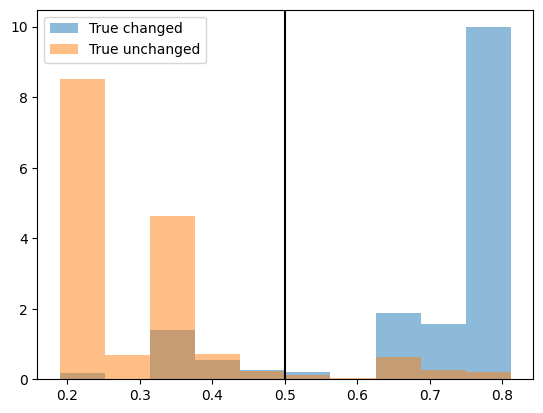

In [245]:
y_test_pred_prob_t = y_test_pred_prob[y_test == True][:, 1]
y_test_pred_prob_f = y_test_pred_prob[y_test == False][:, 1]
plt.hist(y_test_pred_prob_t, density=True, alpha = 0.5, label="True changed")
plt.hist(y_test_pred_prob_f, density=True, alpha = 0.5, label="True unchanged")
plt.axvline(0.5, color='k')
# plt.yscale("log")
plt.legend()
plt.show()

0


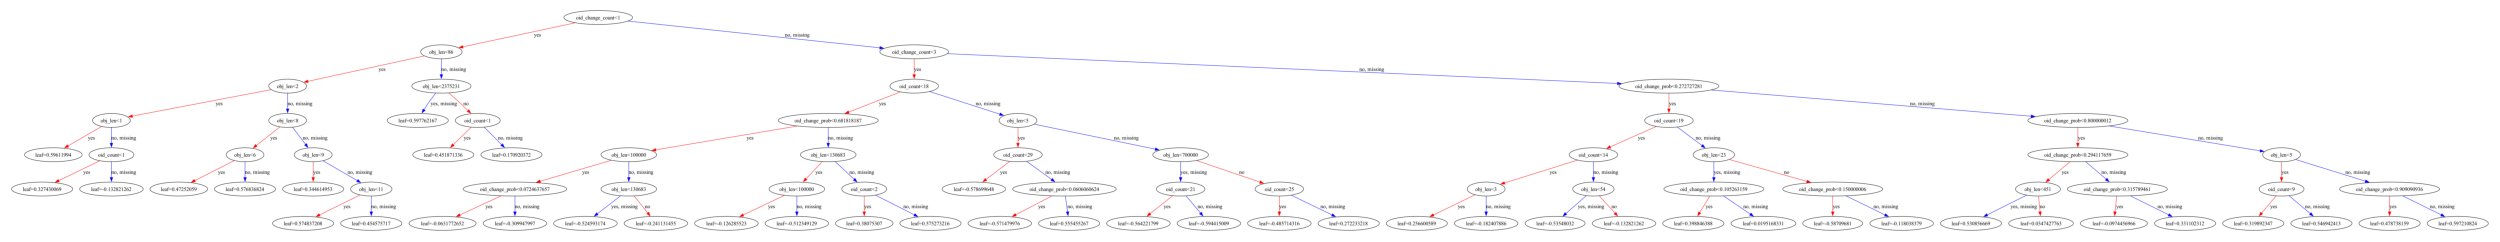

1


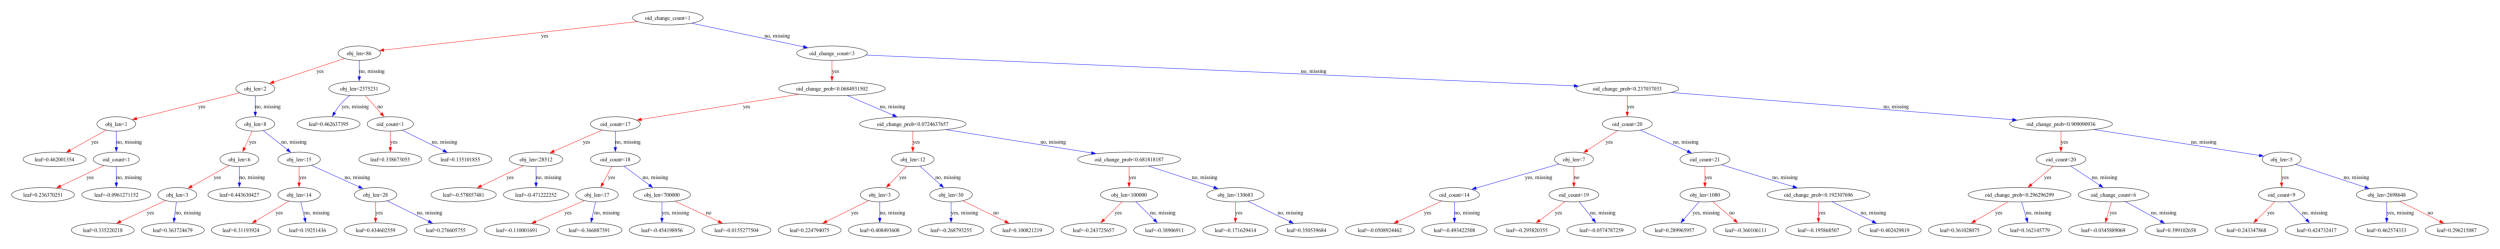

2


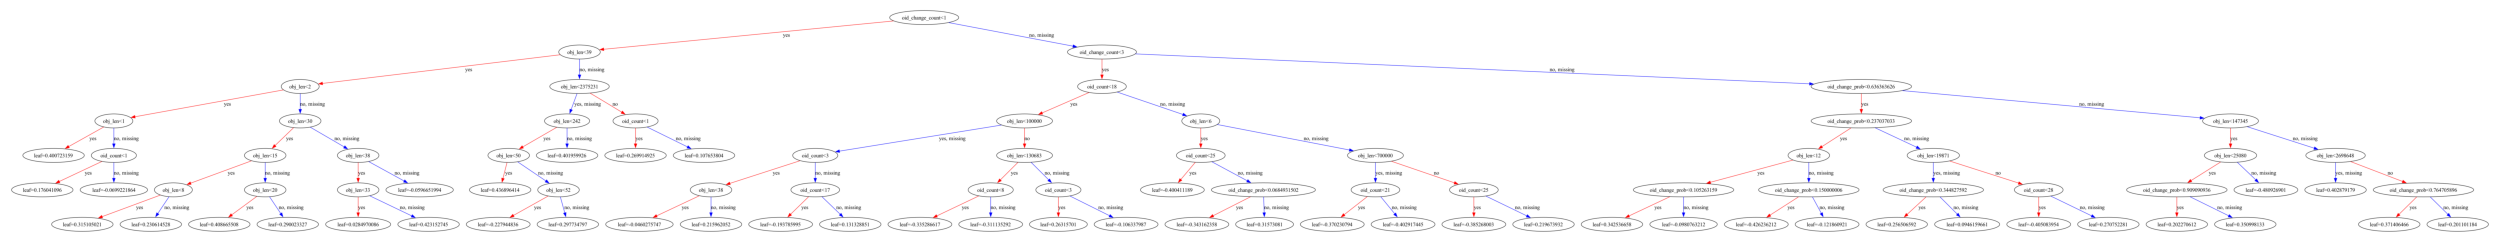

In [252]:
RS, SZ = 1.6, 20
for idx in range(len(bst.get_booster().get_dump())):
    print(idx)
    fig, ax = plt.subplots(figsize=(RS * SZ, SZ))
    xgb.plot_tree(bst, num_trees=idx, ax=ax)
    plt.show()